# 1. Prelimitary

In [1]:
import numpy as np
import random
from project_utils import load_train_set, load_test_set, hint

random.seed()
np.random.seed()

TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'

hint("Loading train set...")
train = load_train_set(TRAIN_PATH)

hint("Done!")

Done!


# 2. Preprocessing

In [2]:
from skimage.color import rgb2gray
from skimage.transform import resize

IMAGE_DIM = (256, 256)
INVERSE_THRESHOLD = 0.3

def standardize_images(img_list, shape=IMAGE_DIM, inverse_threshold=INVERSE_THRESHOLD):
    """make grayscale, resize, and remove light background"""
    to_return = [np.expand_dims(rgb2gray(img), axis=-1) for img in img_list]
    to_return = [resize(img, shape) for img in to_return]
    for i, img in enumerate(to_return):
        if np.mean(img) > inverse_threshold:
            to_return[i] = 1 - img
    return np.array(to_return)

def standardize_masks(mask_list, shape=IMAGE_DIM):
    """make grayscale and resize"""
    to_return = [np.expand_dims(mask, axis=-1) for mask in mask_list]
    to_return = [resize(mask, shape) for mask in to_return]
    return np.array(to_return, dtype=np.bool)

In [3]:
from project_utils import standardize_images
from sklearn.model_selection import train_test_split

VALIDATION_SIZE = 0.2

hint("Working on X...")
X = standardize_images(train['image'], shape=IMAGE_DIM)
hint("Working on Y...")
Y = standardize_images(train['mask'], shape=IMAGE_DIM, dtype=np.bool)
hint("Working on X_...")

Xtr, Xva, Ytr, Yva = train_test_split(X, Y, test_size=VALIDATION_SIZE)

hint("Done!")

Done!


In [4]:
def augment_data(X, Y):
    """
    Add augmented data to a copy of the original data
    
    method currently using: rotate 180
    
    :return: a new array containing the original and the augmented data
    """
    X_, Y_ = X, Y

    X_ = np.append(X_, np.flip(np.flip(X, axis=1), axis=2), axis=0)
    Y_ = np.append(Y_, np.flip(np.flip(Y, axis=1), axis=2), axis=0)

    return X_, Y_

In [5]:
Xtr, Ytr = augment_data(Xtr, Ytr)
print("%d samples added (total %d)" % (Xtr.shape[0]-X.shape[0]*(1-VALIDATION_SIZE), Xtr.shape[0]))

536 samples added (total 1072)


In [6]:
from sklearn.utils import shuffle

Xtr, Ytr = shuffle(Xtr, Ytr)

# 3. Model

In [7]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, concatenate
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D
from keras.optimizers import Adam

CONV_KERNEL = (3, 3)
TRAN_KERNEL = (3, 3)
CONV_ACTIVATION = 'relu'
CONV_PADDING = 'same'
CONV_KERNEL_INIT = 'he_normal'
POOLING_SIZE = (2, 2)
OPTIMIZER = Adam(lr=0.0005)

def build_conv_layer(filter_size):
    """
    build a convolution layer using the preset hyperparameters
    """
    return Conv2D(
        filter_size, 
        kernel_size=CONV_KERNEL,
        padding=CONV_PADDING,
        activation=CONV_ACTIVATION,
        kernel_initializer=CONV_KERNEL_INIT
    )

def build_conv_block(connect, depth, basesize, dropout):
    """
    build a 2-convolutional-layer block
    """
    filter_size = basesize*(2**depth)
    x = build_conv_layer(filter_size)(connect)
    if dropout > 0:
        x = Dropout(dropout)(x)
    x = build_conv_layer(filter_size)(x)
    return x

def build_upsample_block(connect, merge, depth, basesize):
    """
    build a upsampling block
    """
    filter_size = basesize*(2**depth)
    x = Conv2DTranspose(
        filter_size, 
        TRAN_KERNEL, 
        strides=POOLING_SIZE, 
        padding=CONV_PADDING
    )(connect)
    return concatenate([x, merge])

c:\users\chuanli\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
def get_model(basesize, dropout):
    np.random.seed(42)
    
    # input layer
    inputs = Input((IMAGE_DIM + (1,)))

    # downsampling layers (left of the U)
    down_conv_0 = build_conv_block(inputs, 0, basesize, dropout)
    down_pool_0 = MaxPooling2D(POOLING_SIZE)(down_conv_0)
    down_conv_1 = build_conv_block(down_pool_0, 1, basesize, dropout)
    down_pool_1 = MaxPooling2D(POOLING_SIZE)(down_conv_1)
    down_conv_2 = build_conv_block(down_pool_1, 2, basesize, dropout)
    down_pool_2 = MaxPooling2D(POOLING_SIZE)(down_conv_2)
    down_conv_3 = build_conv_block(down_pool_2, 3, basesize, dropout)
    down_pool_3 = MaxPooling2D(POOLING_SIZE)(down_conv_3)

    # bottom layer
    conv_bottom = build_conv_block(down_pool_3, 4, basesize, dropout)

    # upsampling layers (right of the U)
    upsample_3 = build_upsample_block(conv_bottom, down_conv_3, 3, basesize)
    up_conv_3 = build_conv_block(upsample_3, 3, basesize, dropout)
    upsample_2= build_upsample_block(up_conv_3, down_conv_2, 2, basesize)
    up_conv_2= build_conv_block(upsample_2, 2, basesize, dropout)
    upsample_1= build_upsample_block(up_conv_2, down_conv_1, 1, basesize)
    up_conv_1= build_conv_block(upsample_1, 1, basesize, dropout)
    upsample_0= build_upsample_block(up_conv_1, down_conv_0, 0, basesize)
    up_conv_0= build_conv_block(upsample_0, 0, basesize, dropout)

    # output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up_conv_0)

    # compile
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(
        optimizer=OPTIMIZER, 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    return model

test_hypers = [
    (16, 0.1),
    (32, 0.1),
    (16, 0.4),
    (32, 0.4),
]

labels = [
    "dropout-, basesize-",
    "dropout-, basesize+",
    "dropout+, basesize-",
    "dropout+, basesize+",
]

In [9]:
from keras.models import load_model
from sklearn.model_selection import train_test_split
import gc

BATCH_SIZE = 16
EPOCHS = 50
VALIDATION_SIZE = 0.1

history = []
for i, (label, th) in enumerate(zip(labels, test_hypers)):
    hint("Working on model %d/%d (%s)" % (i+1, len(test_hypers), label))
    model = get_model(th[0], th[1])
    history.append(model.fit(
        Xtr, Ytr, 
        validation_data=(Xva, Yva),
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS, 
        verbose=2
    ))
    del model
    gc.collect()

Working on model 4/4 (dropout+, basesize+)
Train on 1072 samples, validate on 134 samples
Epoch 1/50
 - 19s - loss: 0.3903 - acc: 0.8363 - val_loss: 0.2413 - val_acc: 0.8462
Epoch 2/50
 - 18s - loss: 0.1899 - acc: 0.9223 - val_loss: 0.2016 - val_acc: 0.9091
Epoch 3/50
 - 18s - loss: 0.1374 - acc: 0.9466 - val_loss: 0.1652 - val_acc: 0.9345
Epoch 4/50
 - 18s - loss: 0.1180 - acc: 0.9544 - val_loss: 0.1411 - val_acc: 0.9428
Epoch 5/50
 - 18s - loss: 0.1033 - acc: 0.9592 - val_loss: 0.1303 - val_acc: 0.9468
Epoch 6/50
 - 18s - loss: 0.0994 - acc: 0.9602 - val_loss: 0.1237 - val_acc: 0.9515
Epoch 7/50
 - 18s - loss: 0.0957 - acc: 0.9613 - val_loss: 0.1151 - val_acc: 0.9548
Epoch 8/50
 - 18s - loss: 0.0906 - acc: 0.9629 - val_loss: 0.1177 - val_acc: 0.9535
Epoch 9/50
 - 18s - loss: 0.0913 - acc: 0.9629 - val_loss: 0.1128 - val_acc: 0.9542
Epoch 10/50
 - 18s - loss: 0.0873 - acc: 0.9641 - val_loss: 0.1260 - val_acc: 0.9496
Epoch 11/50
 - 18s - loss: 0.0858 - acc: 0.9646 - val_loss: 0.1128 - 

# 4. Conclusion

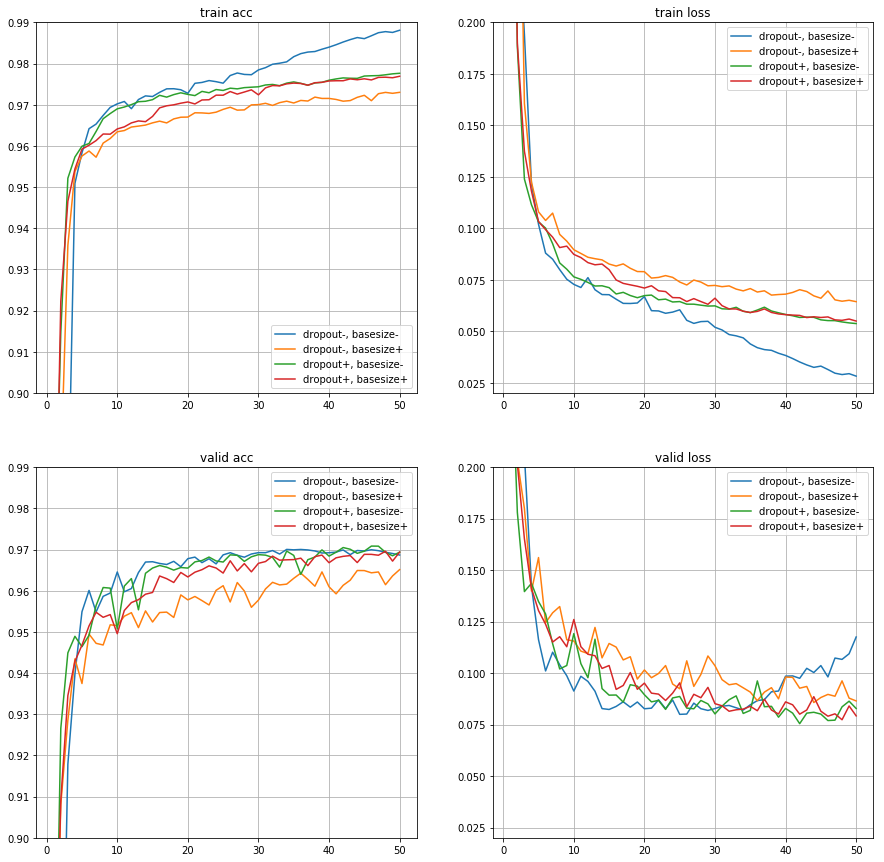

In [12]:
import matplotlib.pyplot as plt

_, axis = plt.subplots(2, 2, figsize=(15, 15))
x_axis = range(1, EPOCHS+1)
for h, l in zip(history, labels):
    axis[0, 0].plot(x_axis, h.history['acc'], label=l)
    axis[0, 1].plot(x_axis, h.history['loss'], label=l)
    axis[1, 0].plot(x_axis, h.history['val_acc'], label=l)
    axis[1, 1].plot(x_axis, h.history['val_loss'], label=l)
axis[0, 0].set_title('train acc')
axis[0, 0].set_ylim(0.9, 0.99)
axis[0, 1].set_title('train loss')
axis[0, 1].set_ylim(0.02, 0.2)
axis[1, 0].set_title('valid acc')
axis[1, 0].set_ylim(0.9, 0.99)
axis[1, 1].set_title('valid loss')
axis[1, 1].set_ylim(0.02, 0.2)
for r in range(2):
    for c in range(2):
        axis[r, c].legend()
        axis[r, c].grid(True)
plt.show()